# Training Set

In [873]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.externals import joblib
%matplotlib inline

### Read raw training data

In [874]:
amazon = pd.read_csv('amazon_data/raw_data_train.csv')
print(amazon.shape)

(364000, 14)


In [875]:
print(amazon.head())
print(amazon['helpful'].mean())

   Unnamed: 0  Unnamed: 0.1      Id   ProductId          UserId  \
0      166886        265042  265043  B000H7EE1M  A1MDABDYVCY1EP   
1      252324        304804  304805  B000CQ4D50  A1V6H7XMJ17TTT   
2       63802        535712  535713  B003VXHGDM  A324GNX6R2MF9V   
3       68771        174477  174478  B003Z54Q7A  A22EDIRG16DP7H   
4       60437        249568  249569  B001LGGH54  A3SQQYS79AV13M   

                 ProfileName  HelpfulnessNumerator  HelpfulnessDenominator  \
0                    shopper                     1                       2   
1                    Krysten                     0                       0   
2           J. L. Sutherland                     1                       1   
3                Mizbabeeace                     0                       0   
4  Terri J. Rice "ricepaper"                     0                       0   

   Score        Time                       Summary  \
0      4  1263513600  good tea, terrible packaging   
1      5  1184889600

### Feature extraction on natural language data

In [876]:
# # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
# from sklearn.feature_extraction.text import CountVectorizer
# vectorizer = CountVectorizer()
# corpus = amazon.Text.as_matrix()
# X_bag_of_words = vectorizer.fit_transform(corpus)
# print(X_bag_of_words.toarray())

In [877]:
# vectorize Bag of Words from review text; as sparse matrix
from sklearn.feature_extraction.text import HashingVectorizer
hv = HashingVectorizer(n_features=2 ** 20, non_negative=True)
X_hv = hv.fit_transform(amazon.Text)
print(X_hv.shape)

/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/hashing.py:102: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/hashing.py:102: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)


(364000, 1048576)


In [878]:
type(X_hv)

scipy.sparse.csr.csr_matrix

In [879]:
# We want to be able to use this model fit on other data (the test set)
# So let's save a copy of this instance of HashingVectorizer to be able to transform other data with this fit
# http://scikit-learn.org/stable/modules/model_persistence.html
joblib.dump(hv, 'hv.pkl') # pickle

['hv.pkl']

In [880]:
# http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer()
X_tfidf = transformer.fit_transform(X_hv)

joblib.dump(transformer, 'transformer.pkl') # pickle

['transformer.pkl']

In [881]:
print(type(X_tfidf))

<class 'scipy.sparse.csr.csr_matrix'>


### Create additional quantitative features

In [882]:
# features from Amazon.csv to add to feature set
amazon['reviewLen'] = amazon['Text'].str.len()

X_quant_features = amazon[["Summary", "reviewLen"]]
#i can add more features here
print(X_quant_features.head(100))
print(type(X_quant_features))

                                              Summary  reviewLen
0                        good tea, terrible packaging        461
1                                     Excellent snack        515
2                                         Delectable!        196
3                               Best taro mix found!!        302
4                                  Refreshingly Tasty        458
5                              3g. Fiber Per Serving!        271
6                                               Yummy        122
7                                Highly reommmed Blue        374
8                             WINDSOR COCA TEA-AMAZON        400
9                                           good food        339
10                                             Great.        244
11                   Mostly just really sweet cashews        693
12                         Nice Deal for Mediocre Tea        637
13                                          Not a Fan        228
14                       

### Combine all quantitative features into a single sparse matrix

In [883]:
from scipy.sparse import csr_matrix, hstack
X_quant_features_csr = csr_matrix(X_quant_features)
X_combined = hstack([X_tfidf, X_quant_features_csr])
X_matrix = csr_matrix(X_combined) # convert to sparse matrix
print(X_matrix.shape)

TypeError: no supported conversion for types: (dtype('O'),)

In [884]:
# look at an example of a "row" of a sparse matrix
print(X_matrix[100])

  (0, 6874)	0.12387096469329067
  (0, 19830)	0.11028602912185938
  (0, 20465)	0.4965576305844725
  (0, 23579)	0.061082530894127816
  (0, 24734)	0.05851867013245605
  (0, 40057)	0.05347582383647497
  (0, 41349)	0.1271450746777187
  (0, 51910)	0.09037111462591849
  (0, 58093)	0.2855893777749311
  (0, 60647)	0.11338004033377033
  (0, 66007)	0.18246411740423238
  (0, 86198)	0.05771378725659435
  (0, 88541)	0.05391637014697701
  (0, 89173)	0.1741961051523677
  (0, 109683)	0.07258966842484643
  (0, 110558)	0.045456348969680205
  (0, 118455)	0.09484290445936568
  (0, 122517)	0.2101582519625519
  (0, 122646)	0.11132455154370903
  (0, 139439)	0.1204327045559504
  (0, 141568)	0.15873944902382706
  (0, 146494)	0.09490089957505006
  (0, 146826)	0.26846900910030225
  (0, 148489)	0.06601785924865157
  (0, 150916)	0.3140975251383262
  (0, 156782)	0.09158275891141925
  (0, 161110)	0.07989527333612703
  (0, 165847)	0.07363379168680663
  (0, 167353)	0.10584009553383075
  (0, 168098)	0.06326555006208187


### Create `X`, scaled matrix of features

In [885]:
# feature scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=False)
X = sc.fit_transform(X_matrix)
print(X.shape)

joblib.dump(sc, 'sc.pkl') # pickle

(364000, 262146)


['sc.pkl']

### create `y`, vector of Labels

In [886]:
y = amazon['helpful'].values
print(type(y))

<class 'numpy.ndarray'>


# fit models

In [887]:
from my_measures import BinaryClassificationPerformance

### MODEL: Naive Bayes

In [888]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X, y)
MultinomialNB(alpha=2, fit_prior=True)
joblib.dump(nbs, 'nbs.pkl') # pickle

nbs_performance = BinaryClassificationPerformance(nbs.predict(X), y, 'nbs')
nbs_performance.compute_measures()
print(nbs_performance.performance_measures)

{'Pos': 26587, 'Neg': 337413, 'TP': 17064, 'TN': 300549, 'FP': 36864, 'FN': 9523, 'Accuracy': 0.8725631868131868, 'Precision': 0.3164218958611482, 'Recall': 0.6418174295708429, 'desc': 'nbs'}


### MODEL: Perceptron

### What is the distribution of weights, OLS vs. ridge? 

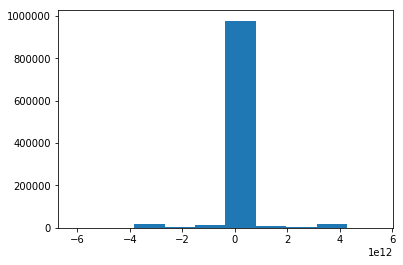

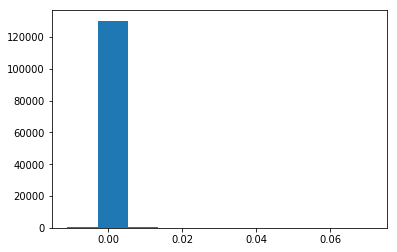

In [889]:
plt.hist(ols.coef_[0])
plt.show()

plt.hist(rdg.coef_[0])
plt.show()

### ROC plot to compare performance of various models and fits

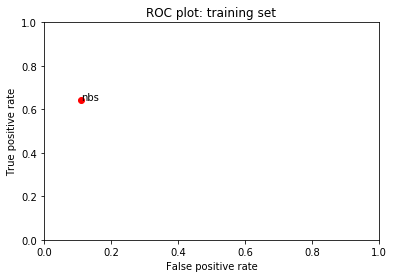

In [890]:
fits = [nbs_performance]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'ro')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: training set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

## a digression: looking inside the `rdg` object

[documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeClassifier.html)

In [ ]:
dir(rdg)

In [ ]:
rdg.get_params()

In [ ]:
type(rdg.coef_)

In [ ]:
rdg.coef_.shape

In [ ]:
print(rdg.coef_[0])

In [ ]:
plt.hist(rdg.coef_[0])
plt.show()

# looking at reviews based on their classification

Let's say we decide that Ridge Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

In [ ]:
amazon.loc[0, "Text"]

In [ ]:
amazon.loc[0, "helpful"]

In [ ]:
ridge_predictions = rdg.predict(X)

In [ ]:
ridge_predictions.shape

In [ ]:
print(ridge_predictions)

In [ ]:
# false positives

import random, time

for i in range(0, len(ridge_predictions)):
    if (ridge_predictions[i] == True):
        if (amazon.loc[i, "helpful"] == False):
            if (random.uniform(0, 1) < 0.05):
                print(i)
                print(time.strftime('%Y-%m-%d %H:%M:%S', time.gmtime(amazon.loc[i, "Time"])))
                print(amazon.loc[i, "Score"])
                print(amazon.loc[i, "HelpfulnessDenominator"])
                print(amazon.loc[i, "ProductId"])
                print(amazon.loc[i, "Text"])
                print('* * * * * * * * * ')